In [1]:
from IPython.core.magic import (
    register_line_magic,
    register_cell_magic,
    register_line_cell_magic,
    magics_class,
    Magics
)
from IPython import get_ipython
from cProfile import Profile
from pstats import SortKey, Stats
import sys, os, re, subprocess
@register_line_cell_magic
def profile(line, cell=None):
    """
        `profile`
    Profile the code by using cProfile and pstats, and print the cumulative
    time spent on each function.
    """
    if cell is None:
        code = line
    # TODO: Implement the logic for getting configs from the %%profile
    else:
        code = cell
        config = line
    old_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    _profile = Profile()
    _profile.runctx(code, globals(), locals())
    sys.stdout = old_stdout
    s = Stats(_profile)
    s.strip_dirs()
    s.sort_stats(SortKey.CUMULATIVE)
    s.print_callees()

In [2]:
%load_ext autoreload
%autoreload 2

#<font color='orange'>Basics</font>

In [3]:
seeds = [120054, 388388, 570334, 907360, 938870]
percent_bads = [0.7, 0.8, 0.9, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.36, 0.4]
sizes = [1000, 5000, 10000]
contaminations = [0.12, ]#0.13, 0.14, 0.15, 0.16, 0.18, 0.2, ]#0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4]

len(seeds)*len(percent_bads)*len(sizes)*len(contaminations)#*12/1024#*2/60

285

In [4]:
#@title **Location** of the dataset
path =  "../data/HomeCredit/"
process_path = "../data/ProcessedData/"
save_path = "../tests/"
ri_datasets_path = "../data/riData/"

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import secrets
import joblib
import sys
import os
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from scipy.stats import ks_2samp
from lightgbm import LGBMClassifier
from pathlib import Path
from sklearn.metrics import (roc_auc_score)
from sklearn.model_selection import KFold


In [6]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                            f1_score, precision_score, recall_score,
                            roc_auc_score, roc_curve)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelSpreading

In [8]:
import credit_pipeline.data_exploration as dex
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri

from submodules.topsis_python import topsis as top
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
import seaborn as sns

In [9]:
!du -sh ../data/riData/Models/TN-2010/*

657M	../data/riData/Models/TN-2010/120055
656M	../data/riData/Models/TN-2010/388389
656M	../data/riData/Models/TN-2010/570335
657M	../data/riData/Models/TN-2010/907361
656M	../data/riData/Models/TN-2010/938871


In [10]:
ls -l -h ../data/riData/Models/TN-2009/

total 20K
drwxrwxr-x 2 athyrson athyrson 4,0K jun 28 16:04 120054/
drwxrwxr-x 2 athyrson athyrson 4,0K jun 28 16:03 388388/
drwxrwxr-x 2 athyrson athyrson 4,0K jun 28 16:02 570334/
drwxrwxr-x 2 athyrson athyrson 4,0K jun 28 15:59 907360/
drwxrwxr-x 2 athyrson athyrson 4,0K jun 28 16:00 938870/


In [11]:
!find ../data/riData/Models -type f | wc -l

591


In [12]:
seeds = [120054, 388388, 570334, 907360, 938870]
year = 2009
file_init = pd.DataFrame()

for seed_number in seeds:
    year = year + (year - 2009)
    folder = os.path.join(ri_datasets_path,f'Data/TN-{year}/{seed_number}/')
    print(f'there are {len(os.listdir(folder))} files in {folder}')

    for file in os.listdir(folder):
        if file_init.shape == (0,0):
            file_init = pd.read_parquet(os.path.join(folder, file))
        filename = os.path.join(folder, file)
        try:
            pd.read_parquet(filename).shape == file_init.shape
        except Exception as e:
            print(f'Error in {filename}: {e}')
    print(file_init.shape)

there are 57 files in ../data/riData/Data/TN-2009/120054/
(33680, 2)
there are 57 files in ../data/riData/Data/TN-2009/388388/
(33680, 2)
there are 57 files in ../data/riData/Data/TN-2009/570334/
(33680, 2)
there are 57 files in ../data/riData/Data/TN-2009/907360/
(33680, 2)
there are 57 files in ../data/riData/Data/TN-2009/938870/
(33680, 2)


In [13]:
pd.DataFrame().shape


(0, 0)

In [14]:
seeds = [120054, 388388, 570334, 907360, 938870]
percent_bads = [0.07, 0.08, 0.09, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.36, 0.4]
sizes = [1000, 5000, 10000]

In [15]:
print(len(percent_bads)*len(sizes))

57


In [16]:
seed_number = 388389
year = 2010
size = 1000
p_value = 0.28
contamination_threshold = 0.12

params_dict = {'seed_number': seed_number,
                    'year': year,
                    'size': size,
                    'p_value': p_value,
                    'contamination_threshold': contamination_threshold}

In [17]:
datapath_ex = os.path.join(ri_datasets_path,f'Data/TN-{year}/{seed_number}/{size}-{p_value}-{contamination_threshold}.parquet')

In [18]:
data_ex = pd.read_parquet(datapath_ex)

In [19]:
data_ex

,first_it,label
index,,
96900,-1,-1
96902,-1,-1
156679,-1,-1
156704,-1,-1
151298,-1,-1
...,...,...
95406,50,1
95328,50,1
95338,50,0


In [20]:
os.path.join(ri_datasets_path,f'Data/Load/{seed_number}_{year}')

'../data/riData/Data/Load/388389_2010'

In [21]:
ls '../data/riData/Load'

120054_2009/  302461_2010/  388391_2012/  907360_2009/  938872_2011/
120055_2010/  302462/       388392_2013/  907361_2010/  938873_2012/
120056_2011/  302463_2010/  570334_2009/  907362_2011/  942024_2009/
120057_2012/  388388_2009/  570335_2010/  907363_2012/
302461/       388389_2010/  570336_2011/  938870_2009/
302461_2009/  388390_2011/  570337_2012/  938871_2010/


In [22]:
data_ex.loc[data_ex.first_it == 0,'label']

index
1652592    0
1652594    0
1652636    0
1652665    1
1643863    0
          ..
1652649    1
1652652    0
1652654    0
1652656    0
1652605    0
Name: label, Length: 6122, dtype: int64

In [23]:
load_path = os.path.join(ri_datasets_path, f'Load/{seed_number}_{year}')

if Path(f'{load_path}').exists():# and False:
        df_train = pd.read_csv(f'{load_path}/A_train.csv', index_col=0)
        df_val = pd.read_csv(f'{load_path}/A_val.csv', index_col=0)
        df_test = pd.read_csv(f'{load_path}/A_test.csv', index_col=0)
        R_train = pd.read_csv(f'{load_path}/R_train.csv', index_col=0)
        R_val = pd.read_csv(f'{load_path}/R_val.csv', index_col=0)
        R_test = pd.read_csv(f'{load_path}/R_test.csv', index_col=0)
        X_train = df_train.loc[:, df_train.columns != "target"]
        y_train = df_train["target"]
        X_val = df_val.loc[:, df_val.columns != "target"]
        y_val = df_val["target"]
        X_test = df_test.loc[:, df_test.columns != "target"]
        y_test = df_test["target"]

In [24]:
iteration = 50

datapath_ex = os.path.join(ri_datasets_path, f'Data/TN-{year}/{seed_number}/{size}-{p_value}-{contamination_threshold}.parquet')
parquet_df = pd.read_parquet(datapath_ex)

train_i = parquet_df.loc[(data_ex.first_it <= iteration) & (data_ex.first_it >=0) ,:]
rej_left = parquet_df.loc[(data_ex.first_it==-1) ,:]
first_added = R_train.loc[R_train.index.intersection(train_i.index),:]

not_added = parquet_df.loc[(data_ex.first_it==-1) ,:]
df_left = R_train.loc[R_train.index.intersection(not_added.index),:]
df_left = pd.concat([df_left, rej_left], axis=1)

df_i = pd.concat([X_train, first_added], axis=0)
df_i = pd.concat([df_i, train_i], axis=1)

assert df_i.shape[0] == (X_train.shape[0] + first_added.shape[0])

#avoid

In [25]:
df_all = pd.concat([df_i, df_left], axis=0)
X_all = df_all.loc[:, (df_all.columns != "first_it") & (df_all.columns != "label")]
y_all = df_all["label"]
Z_all = df_all["first_it"]
X_all_train = X_all.loc[Z_all == 0, :]
y_all_train = y_all.loc[Z_all == 0]
X_all_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6122 entries, 1651966 to 1637823
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   emp_length      6122 non-null   float64
 1   addr_state      6122 non-null   float64
 2   dti             6122 non-null   float64
 3   loan_amnt       6122 non-null   float64
 4   risk_score      6122 non-null   float64
 5   int_rate        6122 non-null   float64
 6   delinq_2yrs     6122 non-null   float64
 7   annual_inc      6122 non-null   float64
 8   inq_last_6mths  6122 non-null   float64
 9   term            6122 non-null   float64
 10  home_ownership  6122 non-null   float64
 11  revol_util      6122 non-null   float64
dtypes: float64(12)
memory usage: 621.8 KB


In [26]:
pca_pipe = tr.create_pipeline(X_all_train, y_all_train, 
            PCA(n_components=2, random_state = seed_number), )
pca_pipe.fit(X_all_train, y_all_train)
X_pca = pca_pipe.transform(X_all)
X_pca = pd.DataFrame(X_pca, columns = ['Pc1', 'Pc2'], index=X_all.index)

finalDf = pd.concat([X_pca, df_all.loc[:, ['first_it', 'label']]], axis = 1)

In [27]:
finalDf['labeled'] = finalDf['first_it'].apply(lambda x: False if x != 0 else True)

In [28]:
finalDf.first_it.max()

50

In [29]:
# focus on evolution of auc by iteration of ci-ex

In [30]:
def check_labels(df, it):
    """
    first define the labeled column based on the first_it column
    if first_it is -1, then the row is not labeled
    if first_it is 0, then the row is labeled
    if first_it is > 0, then the row is labeled if the current iteration is less than or equal to the first_it
    and not labeled otherwise
    """
    df_it = df.copy()
    df_it.loc[(df_it['first_it'] <= it) & (df_it['first_it'] != -1), 'labeled'] = True
    df_it.loc[~((df_it['first_it'] <= it) & (df_it['first_it'] != -1)), 'labeled'] = False
    
    #then define the current_it column
    df_it.loc[:, 'current_it'] = it
    return df_it

check_labels(finalDf, 50)

,Pc1,Pc2,first_it,label,labeled,current_it
1651966,2.754849,-0.004852,0,1,True,50
1642601,-2.063641,-0.586580,0,0,True,50
1643153,1.026603,0.029206,0,0,True,50
1643380,0.441833,0.790824,0,0,True,50
1644529,-1.556097,-0.080850,0,0,True,50
...,...,...,...,...,...,...
124179,1.571320,-0.948422,-1,-1,False,50
128081,0.235898,-1.300380,-1,-1,False,50
100144,3.922340,-0.808692,-1,-1,False,50
95145,0.770364,-1.820702,-1,-1,False,50


In [31]:
check_labels(finalDf, 2).query('first_it == 50')

,Pc1,Pc2,first_it,label,labeled,current_it
137930,-0.456514,-1.660512,50,1,False,2
164894,-1.175320,-1.547277,50,1,False,2
132415,1.111493,-2.016998,50,1,False,2
162192,-0.410217,-1.074208,50,0,False,2
90899,0.993787,-0.556057,50,0,False,2
...,...,...,...,...,...,...
149353,1.931460,-2.678361,50,1,False,2
111585,0.286173,-1.617100,50,0,False,2
95406,-0.251833,-0.459235,50,1,False,2
130289,-0.576599,-0.848156,50,0,False,2


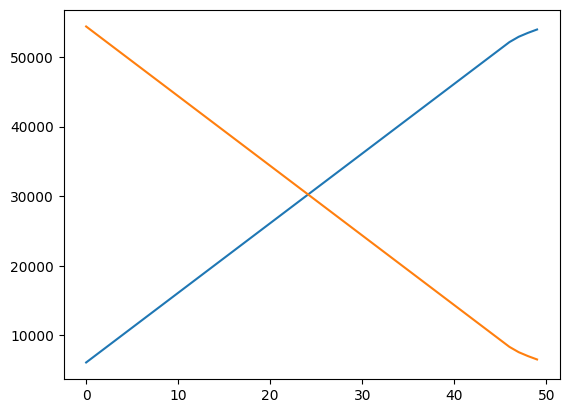

In [32]:
l_dict = {}
for i in range(0, 50):
    temp_df = check_labels(finalDf, i)
    kt = temp_df.loc[temp_df['labeled'] == True, 'labeled'].sum()
    kf = temp_df.shape[0] - kt
    l_dict[i] = {'labeled': kt, 'unlabeled': kf}
l_df = pd.DataFrame(l_dict)
plt.plot(l_df.T)

In [33]:
df_all

,emp_length,addr_state,dti,loan_amnt,risk_score,int_rate,delinq_2yrs,annual_inc,inq_last_6mths,term,home_ownership,revol_util,first_it,label
1651966,1.0,0.146791,11.36,15200.0,622.0,16.820,0.0,30000.0,4.0,60.0,0.126405,91.40,0,1
1642601,1.0,0.132320,18.83,7000.0,762.0,7.510,0.0,110000.0,1.0,36.0,0.150919,2.30,0,0
1643153,3.0,0.150803,22.43,15000.0,687.0,13.110,0.0,80000.0,0.0,36.0,0.126405,87.30,0,0
1643380,10.0,0.103260,12.03,16000.0,712.0,12.730,0.0,110000.0,0.0,36.0,0.156227,82.60,0,0
1644529,8.0,0.150803,7.06,5000.0,787.0,10.620,0.0,25000.0,3.0,36.0,0.150919,19.40,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124179,3.0,0.123660,25.81,10000.0,627.0,14.965,0.0,55000.0,0.0,36.0,0.139241,89.00,-1,-1
128081,3.0,0.242289,20.10,2500.0,613.0,13.290,1.0,50000.0,2.5,36.0,0.139241,23.25,-1,-1
100144,2.0,0.131425,58.46,19000.0,632.0,17.930,0.0,64000.0,1.5,36.0,0.139241,87.30,-1,-1
95145,0.0,0.235007,21.80,5000.0,600.0,13.660,0.0,50000.0,1.0,36.0,0.139241,59.80,-1,-1


In [34]:
check_labels(df_all, 50)

,emp_length,addr_state,dti,loan_amnt,risk_score,int_rate,delinq_2yrs,annual_inc,inq_last_6mths,term,home_ownership,revol_util,first_it,label,labeled,current_it
1651966,1.0,0.146791,11.36,15200.0,622.0,16.820,0.0,30000.0,4.0,60.0,0.126405,91.40,0,1,True,50
1642601,1.0,0.132320,18.83,7000.0,762.0,7.510,0.0,110000.0,1.0,36.0,0.150919,2.30,0,0,True,50
1643153,3.0,0.150803,22.43,15000.0,687.0,13.110,0.0,80000.0,0.0,36.0,0.126405,87.30,0,0,True,50
1643380,10.0,0.103260,12.03,16000.0,712.0,12.730,0.0,110000.0,0.0,36.0,0.156227,82.60,0,0,True,50
1644529,8.0,0.150803,7.06,5000.0,787.0,10.620,0.0,25000.0,3.0,36.0,0.150919,19.40,0,0,True,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124179,3.0,0.123660,25.81,10000.0,627.0,14.965,0.0,55000.0,0.0,36.0,0.139241,89.00,-1,-1,False,50
128081,3.0,0.242289,20.10,2500.0,613.0,13.290,1.0,50000.0,2.5,36.0,0.139241,23.25,-1,-1,False,50
100144,2.0,0.131425,58.46,19000.0,632.0,17.930,0.0,64000.0,1.5,36.0,0.139241,87.30,-1,-1,False,50
95145,0.0,0.235007,21.80,5000.0,600.0,13.660,0.0,50000.0,1.0,36.0,0.139241,59.80,-1,-1,False,50


In [35]:
def check_outliers(dfall, number, it, contamination_threshold=0.12, seed_number=seed_number):
    # Set parameters for the IsolationForest
    iso_params = {"contamination": contamination_threshold, "random_state": seed_number}
    # Create a copy of the input DataFrame to avoid modifying the original data
    df_o = dfall.copy()
    # List of columns to exclude from the analysis
    exclude_cols = ['first_it', 'label', 'labeled', 'current_it']
    # Get the current DataFrame based on the iteration number
    currentDF = check_labels(df_o, it)
    # Select the training data: rows where 'first_it' is less than the iteration number and not equal to -1
    X_train = currentDF.loc[(currentDF['first_it'] < it) & (currentDF['first_it'] != -1),
                            [col for col in currentDF.columns if col not in exclude_cols]]

    # Select the labels for the training data
    y_train = currentDF.loc[(currentDF['first_it'] < it) & (currentDF['first_it'] != -1), 'label']
    # Select the unlabeled data: rows where 'first_it' is -1 or greater than or equal to the iteration number
    X_unl = currentDF.loc[(currentDF['first_it'] == -1) | (currentDF['first_it'] >= it),
                          [col for col in currentDF.columns if col not in exclude_cols]]
    # Initialize and fit the IsolationForest on the training data with the specified label
    iso = tr.create_pipeline(X_train[y_train == number], y_train[y_train == number],
                                                IsolationForest(**iso_params), do_EBE=True, crit = 0)
    # dex.get_shapes(X_train, y_train, X_unl, df_o)
    iso.fit(X_train[y_train == number], y_train[y_train == number])
    # Predict outliers in the unlabeled data
    unl_scores = iso.predict(X_unl)
    # Assign outlier flags to the unlabeled data indices
    currentDF.loc[X_unl.index, f'outlier_{number}'] = unl_scores
    # Assign outlier flag 0 to the training data indices (assuming no outliers in the training data)
    currentDF.loc[X_train.index, f'outlier_{number}'] = 0
    # Convert the outlier flags to integer type
    currentDF[f'outlier_{number}'] = currentDF[f'outlier_{number}'].astype(int)
    # Return the modified DataFrame
    return currentDF


In [36]:
df_all.query('first_it <= 2 & first_it >= 0')

,emp_length,addr_state,dti,loan_amnt,risk_score,int_rate,delinq_2yrs,annual_inc,inq_last_6mths,term,home_ownership,revol_util,first_it,label
1651966,1.0,0.146791,11.36,15200.0,622.0,16.820,0.0,30000.0,4.0,60.0,0.126405,91.40,0,1
1642601,1.0,0.132320,18.83,7000.0,762.0,7.510,0.0,110000.0,1.0,36.0,0.150919,2.30,0,0
1643153,3.0,0.150803,22.43,15000.0,687.0,13.110,0.0,80000.0,0.0,36.0,0.126405,87.30,0,0
1643380,10.0,0.103260,12.03,16000.0,712.0,12.730,0.0,110000.0,0.0,36.0,0.156227,82.60,0,0
1644529,8.0,0.150803,7.06,5000.0,787.0,10.620,0.0,25000.0,3.0,36.0,0.150919,19.40,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95552,2.0,0.200854,2.15,25000.0,753.0,11.305,0.0,75000.0,1.0,36.0,0.139241,26.20,2,0
98929,3.0,0.146791,-1.00,20000.0,774.5,9.500,0.0,200000.0,0.0,36.0,0.139241,8.55,2,0
156861,0.0,0.126354,9.06,10000.0,752.0,9.065,0.0,61000.0,1.5,36.0,0.139241,29.20,2,0
153929,0.0,0.235007,3.69,2000.0,473.0,15.765,0.0,24000.0,4.5,48.0,0.139241,56.50,2,1


In [38]:
check_outliers(df_all, 0, 3)

,emp_length,addr_state,dti,loan_amnt,risk_score,int_rate,delinq_2yrs,annual_inc,inq_last_6mths,term,home_ownership,revol_util,first_it,label,labeled,current_it,outlier_0
1651966,1.0,0.146791,11.36,15200.0,622.0,16.820,0.0,30000.0,4.0,60.0,0.126405,91.40,0,1,True,3,0
1642601,1.0,0.132320,18.83,7000.0,762.0,7.510,0.0,110000.0,1.0,36.0,0.150919,2.30,0,0,True,3,0
1643153,3.0,0.150803,22.43,15000.0,687.0,13.110,0.0,80000.0,0.0,36.0,0.126405,87.30,0,0,True,3,0
1643380,10.0,0.103260,12.03,16000.0,712.0,12.730,0.0,110000.0,0.0,36.0,0.156227,82.60,0,0,True,3,0
1644529,8.0,0.150803,7.06,5000.0,787.0,10.620,0.0,25000.0,3.0,36.0,0.150919,19.40,0,0,True,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124179,3.0,0.123660,25.81,10000.0,627.0,14.965,0.0,55000.0,0.0,36.0,0.139241,89.00,-1,-1,False,3,1
128081,3.0,0.242289,20.10,2500.0,613.0,13.290,1.0,50000.0,2.5,36.0,0.139241,23.25,-1,-1,False,3,-1
100144,2.0,0.131425,58.46,19000.0,632.0,17.930,0.0,64000.0,1.5,36.0,0.139241,87.30,-1,-1,False,3,-1
95145,0.0,0.235007,21.80,5000.0,600.0,13.660,0.0,50000.0,1.0,36.0,0.139241,59.80,-1,-1,False,3,1


In [39]:
def set_current_df(finaldf, dfall, it):
    # Assume check_labels and check_outliers are already defined elsewhere
    currentDF = check_labels(finaldf, it)
    
    # Get the boolean masks for outliers
    outPos_mask = check_outliers(dfall, 1, it).loc[:, 'outlier_1']
    outNeg_mask = check_outliers(dfall, 0, it).loc[:, 'outlier_0']
    
    # Set 'outPos' column based on the mask
    currentDF['outPos'] = outPos_mask
    
    # Set 'outNeg' column based on the mask
    currentDF['outNeg'] = outNeg_mask
    
    return currentDF
    

In [40]:
# .loc[:,['outPos', 'outNeg']]

In [41]:
set_current_df(finalDf, df_all, 50).query('outPos == -1 and outNeg == -1').first_it.value_counts()

first_it
-1     2994
 50      23
Name: count, dtype: int64

In [42]:
finalDf.first_it.value_counts()

first_it
-1     6125
 0     6122
 18    1000
 43    1000
 39    1000
 32    1000
 11    1000
 33    1000
 7     1000
 1     1000
 37    1000
 36    1000
 14    1000
 17    1000
 21    1000
 2     1000
 41    1000
 3     1000
 28    1000
 40    1000
 20    1000
 38    1000
 9     1000
 46    1000
 44    1000
 6     1000
 25    1000
 24    1000
 10    1000
 8     1000
 45    1000
 30    1000
 34    1000
 42    1000
 5     1000
 19    1000
 27    1000
 35    1000
 26    1000
 13    1000
 15    1000
 12    1000
 16    1000
 23    1000
 4     1000
 29    1000
 31    1000
 22    1000
 47     760
 48     558
 49     491
 50     429
Name: count, dtype: int64

In [43]:
set_current_df(finalDf, df_all,4).query('first_it == 4').query('outPos == -1 & outNeg == -1')

,Pc1,Pc2,first_it,label,labeled,current_it,outPos,outNeg
119588,1.570290,-0.054223,4,1,True,4,-1,-1
103762,0.656363,1.805030,4,0,True,4,-1,-1
103849,1.758525,1.354166,4,1,True,4,-1,-1
128380,-1.843163,2.056436,4,0,True,4,-1,-1
146870,4.805875,-0.383837,4,1,True,4,-1,-1
125990,1.981383,1.247019,4,1,True,4,-1,-1
104985,1.281368,0.274468,4,0,True,4,-1,-1
150255,1.409423,0.732615,4,0,True,4,-1,-1
105842,2.875185,-0.993767,4,0,True,4,-1,-1
140719,-0.716804,0.521477,4,0,True,4,-1,-1


In [44]:
for n in range(1, 11):
    aux = set_current_df(finalDf, df_all,n).query('first_it ==@n & (outPos == 1 | outNeg == 1)').shape[0]
    print(f'iteration {n} has {aux} added rows')

iteration 1 has 1000 added rows
iteration 2 has 939 added rows
iteration 3 has 983 added rows
iteration 4 has 981 added rows
iteration 5 has 985 added rows
iteration 6 has 992 added rows
iteration 7 has 992 added rows
iteration 8 has 986 added rows
iteration 9 has 995 added rows
iteration 10 has 990 added rows


In [45]:
# for it in range(1,51):
#     print(f'iteration {it}')
#     print(check_outliers(df_all, finalDf, 0, it).shape)

In [46]:
# finalDf = finalDf.loc[(finalDf['Pc1'] < 100) & (finalDf['Pc2'] < 100),:]
# finalDf

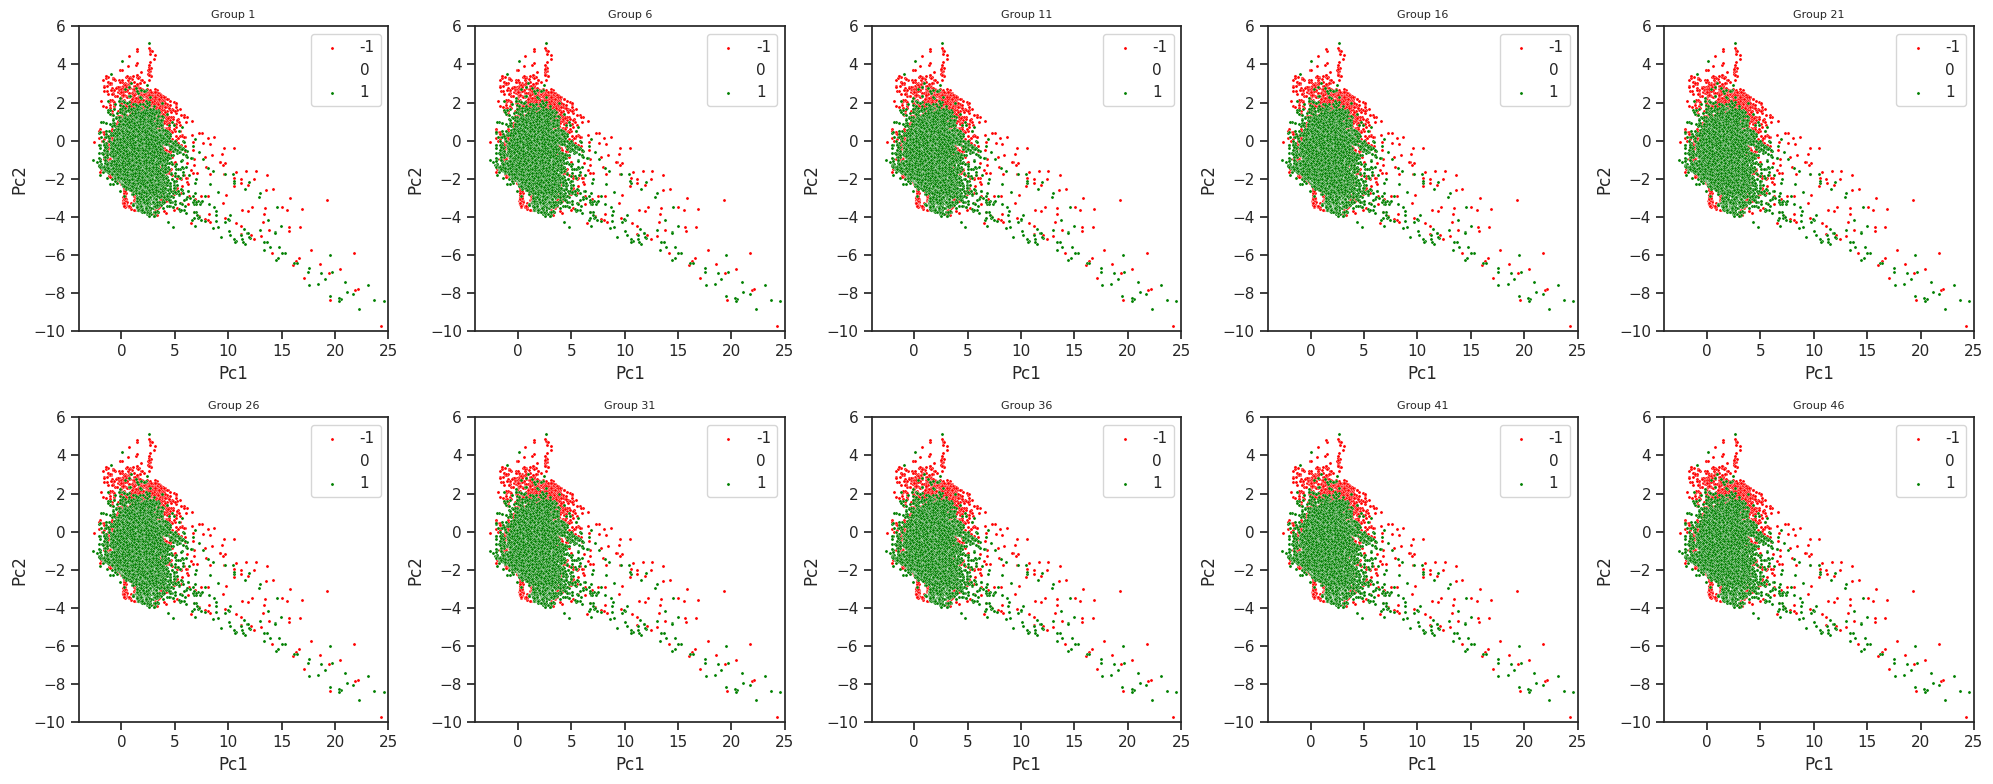

In [47]:
range_it = range(1, finalDf['first_it'].max()+1, 5)
N = len(range_it)

# Calculate the number of rows and columns needed for the grid
n_cols = 5
n_rows = math.ceil(N / n_cols)

sns.set_theme(style="ticks")
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))  # Adjust the figure size dynamically

# Flatten the axs array for easy iteration if there are multiple rows
axs = axs.flatten()

pallet_label = {-1: 'red', 0: 'blue', 1: 'green'}
alpha_label = {-1: 1, 0: 0, 1: 1}
# pallet = {True: 'blue', False: 'red'}
# alpha_values = {True: 1, False: 0.5}


for idx, it in enumerate(range_it):  # Loop through the number of unique first_its
    filtered_data = set_current_df(finalDf, df_all, it)
    ax = axs[idx]

    for label_status in [-1,0,1]:
        subset = filtered_data[filtered_data["label"] == label_status]
        sns.scatterplot(
            x="Pc1", y="Pc2", 
            data=subset,
            s=5, 
            color=pallet_label[label_status], 
            alpha=alpha_label[label_status],
            label=label_status,
            ax=ax,
            legend=True,
        )

    ax.set_title(f'Group {it}', fontsize=8)
    ax.set_ylim([-10, 6])
    ax.set_xlim([-4, 25])

# Turn off the axes for any remaining empty subplots
for j in range(it, n_rows * n_cols):
    fig.delaxes(axs[j])
plt.tight_layout()
plt.savefig(f'scatter-pca-{seed_number}-{year}-{size}-{p_value}-{contamination_threshold}.png')
# plt.show()


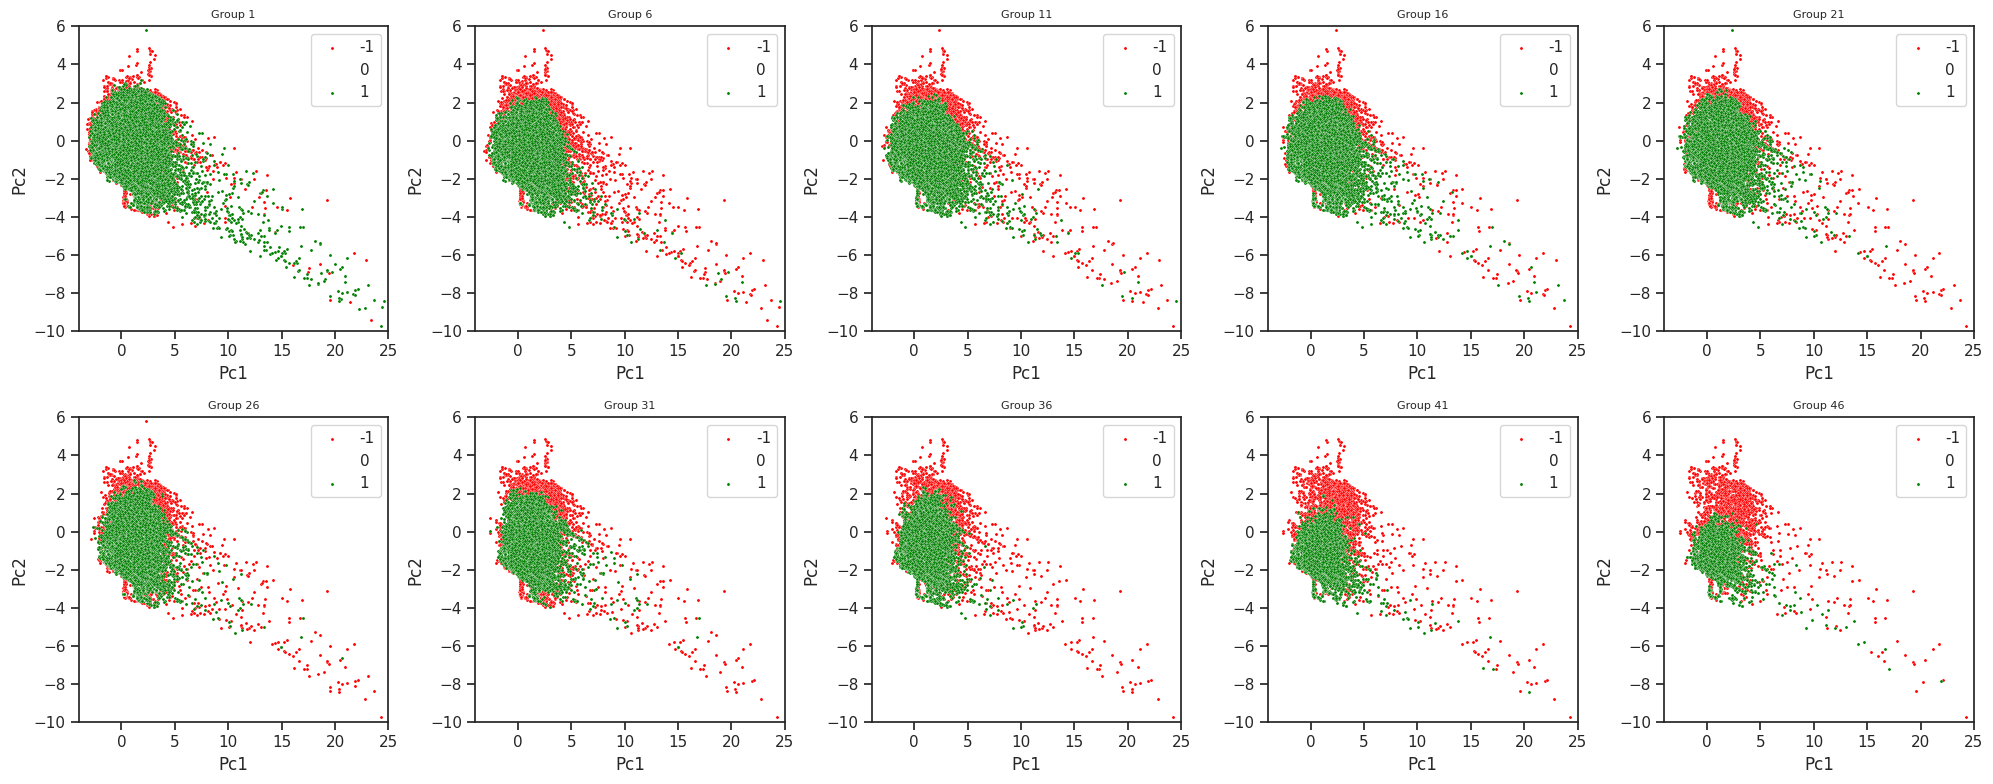

In [48]:
range_it = range(1, finalDf['first_it'].max()+1, 5)
N = len(range_it)

# Calculate the number of rows and columns needed for the grid
n_cols = 5
n_rows = math.ceil(N / n_cols)

sns.set_theme(style="ticks")
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))  # Adjust the figure size dynamically

# Flatten the axs array for easy iteration if there are multiple rows
axs = axs.flatten()

pallet_out = {-1: 'red', 0: 'blue', 1: 'green'}
alpha_out = {-1: 1, 0: 0, 1: 1}
pallet = {True: 'blue', False: 'red'}
alpha_values = {True: 1, False: 0.5}


for idx, it in enumerate(range_it):  # Loop through the number of unique first_its
    filtered_data = set_current_df(finalDf, df_all, it)
    ax = axs[idx]

    for out_status in [-1,0,1]:
        subset = filtered_data[filtered_data["outPos"] == out_status]
        sns.scatterplot(
            x="Pc1", y="Pc2", 
            data=subset,
            s=5, 
            color=pallet_out[out_status], 
            alpha=alpha_out[out_status],
            label=out_status,
            ax=ax,
            legend=True,
        )

    ax.set_title(f'Group {it}', fontsize=8)
    ax.set_ylim([-10, 6])
    ax.set_xlim([-4, 25])

# Turn off the axes for any remaining empty subplots
for j in range(it, n_rows * n_cols):
    fig.delaxes(axs[j])


plt.tight_layout()
# plt.savefig(f'scatter-pca-{seed_number}-{year}-{size}-{p_value}-{contamination_threshold}.png')
# plt.show()


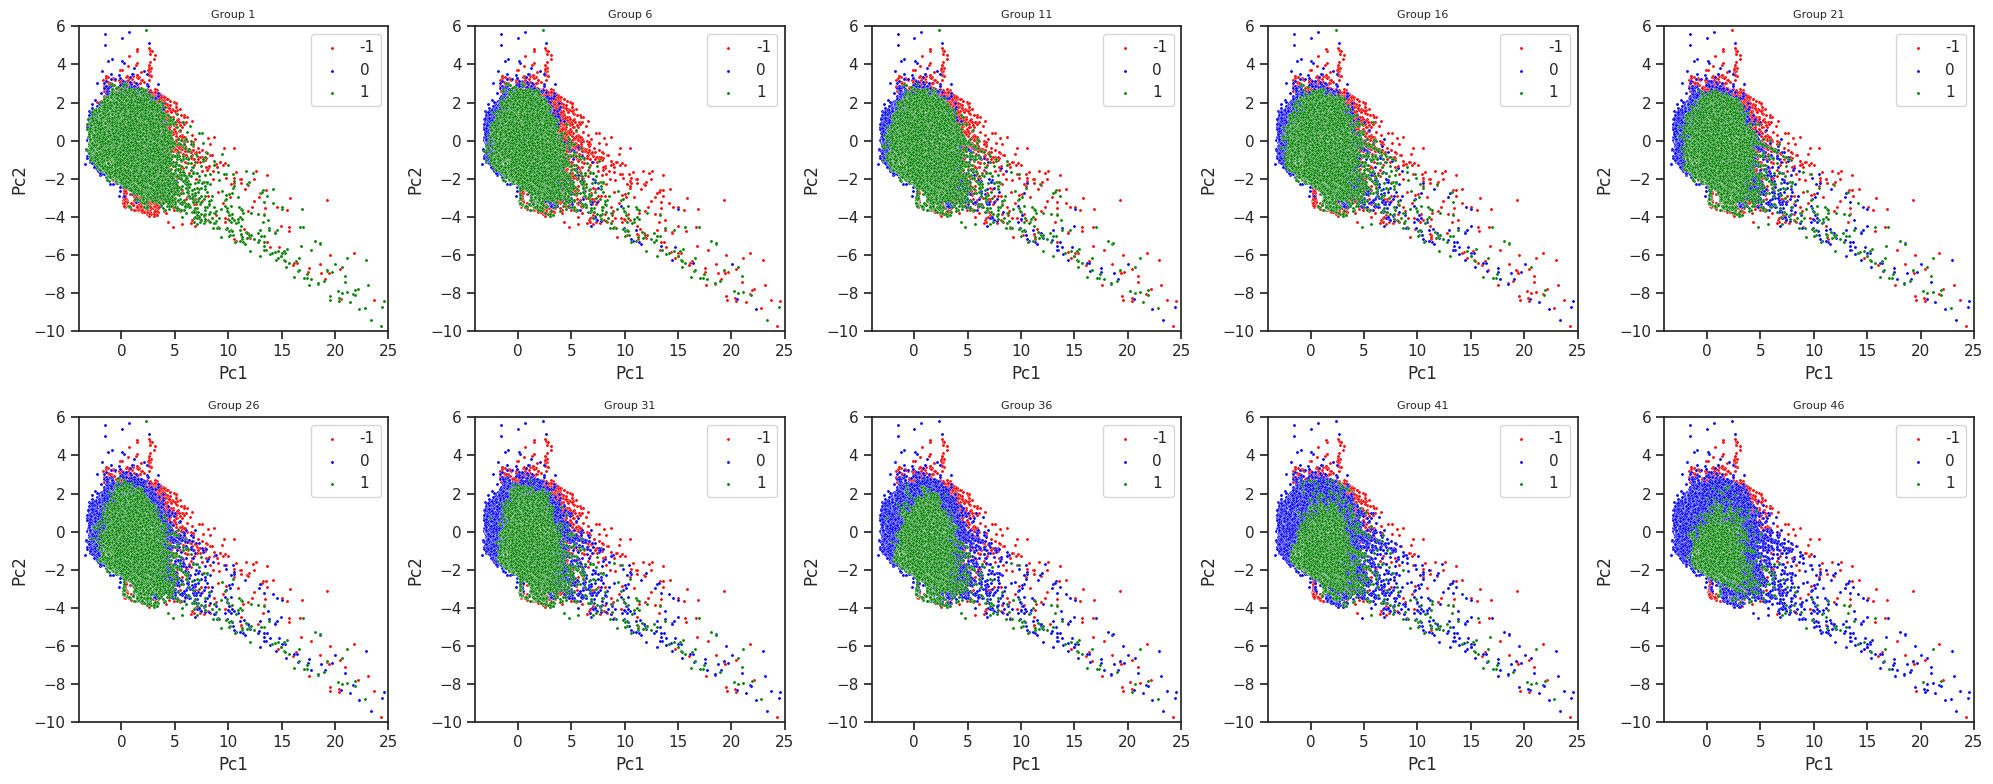

In [62]:
range_it = range(1, finalDf['first_it'].max()+1, 5)
N = len(range_it)

# Calculate the number of rows and columns needed for the grid
n_cols = 5
n_rows = math.ceil(N / n_cols)

sns.set_theme(style="ticks")
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))  # Adjust the figure size dynamically

# Flatten the axs array for easy iteration if there are multiple rows
axs = axs.flatten()

pallet_out = {-1: 'red', 0: 'blue', 1: 'green'}
alpha_out = {-1: 1, 0: 1, 1: 1}
pallet = {True: 'blue', False: 'red'}
alpha_values = {True: 1, False: 0.5}


for idx, it in enumerate(range_it):  # Loop through the number of unique first_its
    filtered_data = set_current_df(finalDf, df_all, it)
    ax = axs[idx]

    for out_status in [-1,0,1]:
        subset = filtered_data[filtered_data["outNeg"] == out_status]
        sns.scatterplot(
            x="Pc1", y="Pc2", 
            data=subset,
            s=5, 
            color=pallet_out[out_status], 
            alpha=alpha_out[out_status],
            label=out_status,
            ax=ax,
            legend=True,
        )

    ax.set_title(f'Group {it}', fontsize=8)
    ax.set_ylim([-10, 6])
    ax.set_xlim([-4, 25])

# Turn off the axes for any remaining empty subplots
for j in range(it, n_rows * n_cols):
    fig.delaxes(axs[j])


plt.tight_layout()
# plt.savefig(f'scatter-pca-{seed_number}-{year}-{size}-{p_value}-{contamination_threshold}.png')
# plt.show()


In [56]:
finalDfkde = finalDf.loc[(finalDf['Pc1'] < 100) & (finalDf['Pc2'] < 100),:]
df_all_kde = df_all.loc[(finalDf['Pc1'] < 100) & (finalDf['Pc2'] < 100),:]
finalDfkde

,Pc1,Pc2,first_it,label,labeled
1651966,2.754849,-0.004852,0,1,True
1642601,-2.063641,-0.586580,0,0,True
1643153,1.026603,0.029206,0,0,True
1643380,0.441833,0.790824,0,0,True
1644529,-1.556097,-0.080850,0,0,True
...,...,...,...,...,...
124179,1.571320,-0.948422,-1,-1,False
128081,0.235898,-1.300380,-1,-1,False
100144,3.922340,-0.808692,-1,-1,False
95145,0.770364,-1.820702,-1,-1,False


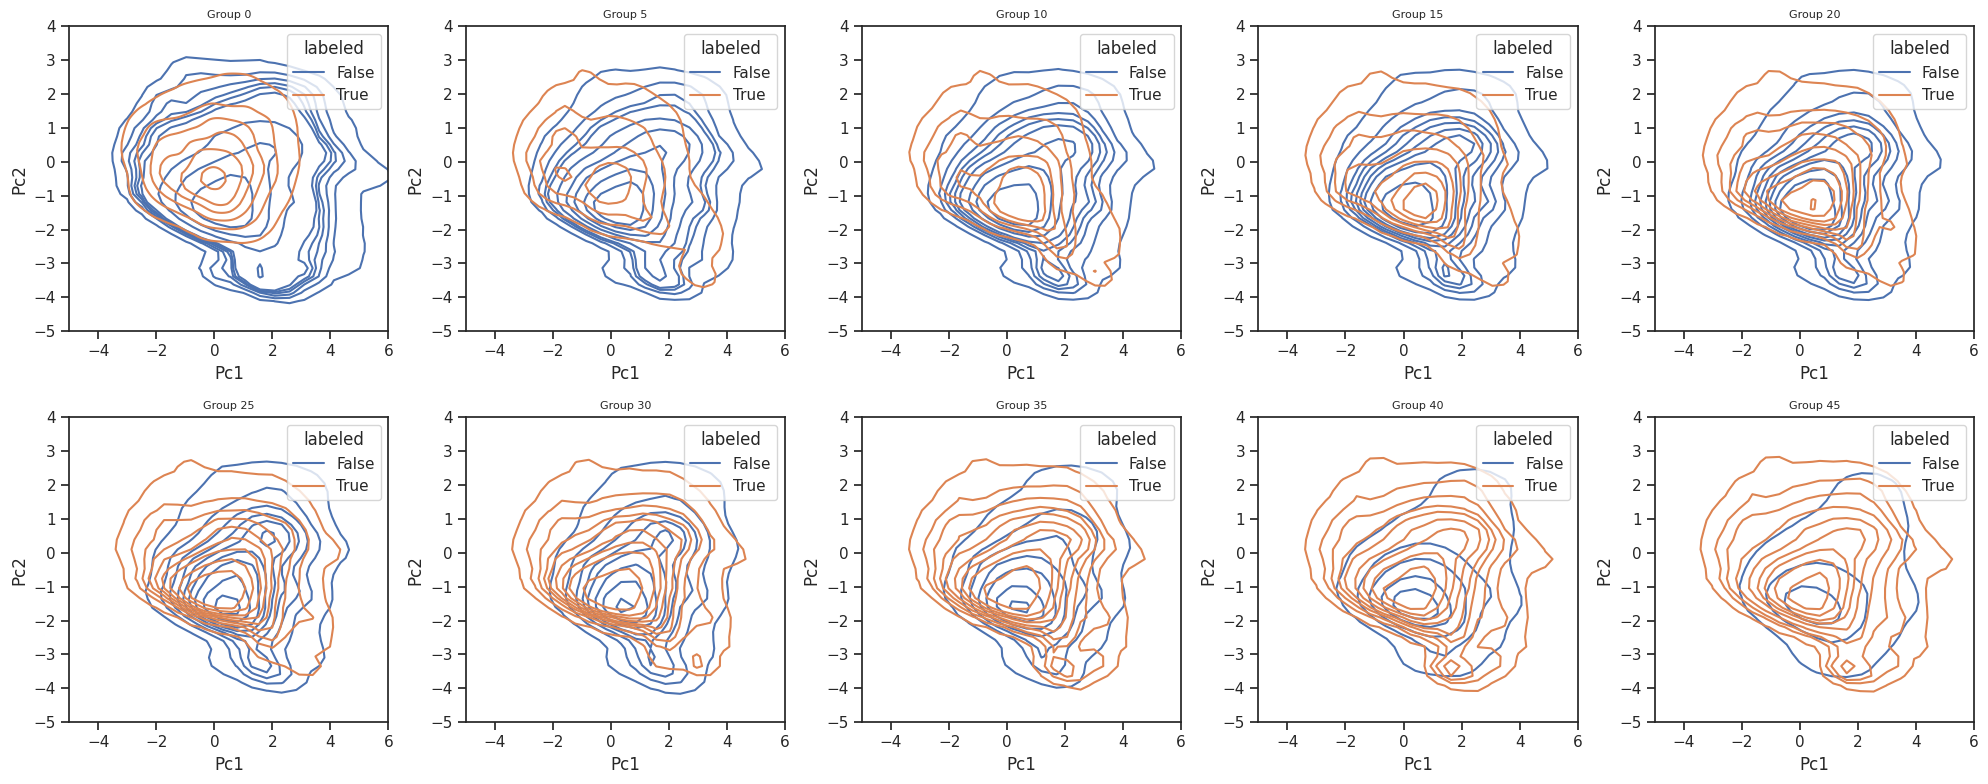

In [55]:
range_it = range(0, finalDfkde['first_it'].max(), 5)
N = len(range_it)

# Calculate the number of rows and columns needed for the grid
n_cols = 5
n_rows = math.ceil(N / n_cols)

sns.set_theme(style="ticks")
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))  # Adjust the figure size dynamically

# Flatten the axs array for easy iteration if there are multiple rows
axs = axs.flatten()

# pallet = {'labeled': 'blue', 'unlabelled': 'red'}
pallet = {True: 'blue', False: 'red'}
alpha_values = {True: 1, False: 0}

kde_list = []

for idx, it in enumerate(range_it):  # Loop through the number of unique first_its
    filtered_data = check_labels(finalDfkde, it)
    ax = axs[idx]

    g = sns.kdeplot(
        x="Pc1", y="Pc2", 
        data=filtered_data,
        hue='labeled',
        fill=False,
        ax = ax,
    )

    kde_list.append(g)
    
    ax.set_title(f'Group {it}', fontsize=8)
    ax.set_ylim([-5, 4])
    ax.set_xlim([-5, 6])

# Turn off the axes for any remaining empty subplots
for j in range(it, n_rows * n_cols):
    fig.delaxes(axs[j])

plt.tight_layout()

plt.savefig(f'kde-pca_lines-{seed_number}-{year}-{size}-{p_value}-{contamination_threshold}.png')
# plt.show()


/home/athyrson/HIAAC/credit_pipeline/playground_credit/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
/home/athyrson/HIAAC/credit_pipeline/playground_credit/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
/home/athyrson/HIAAC/credit_pipeline/playground_credit/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
/home/athyrson/HIAAC/credit_pipeline/playground_credit/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
/home/athyrson/HIAAC/credit_pipeline/playground_credit/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 's'
  cset = cont

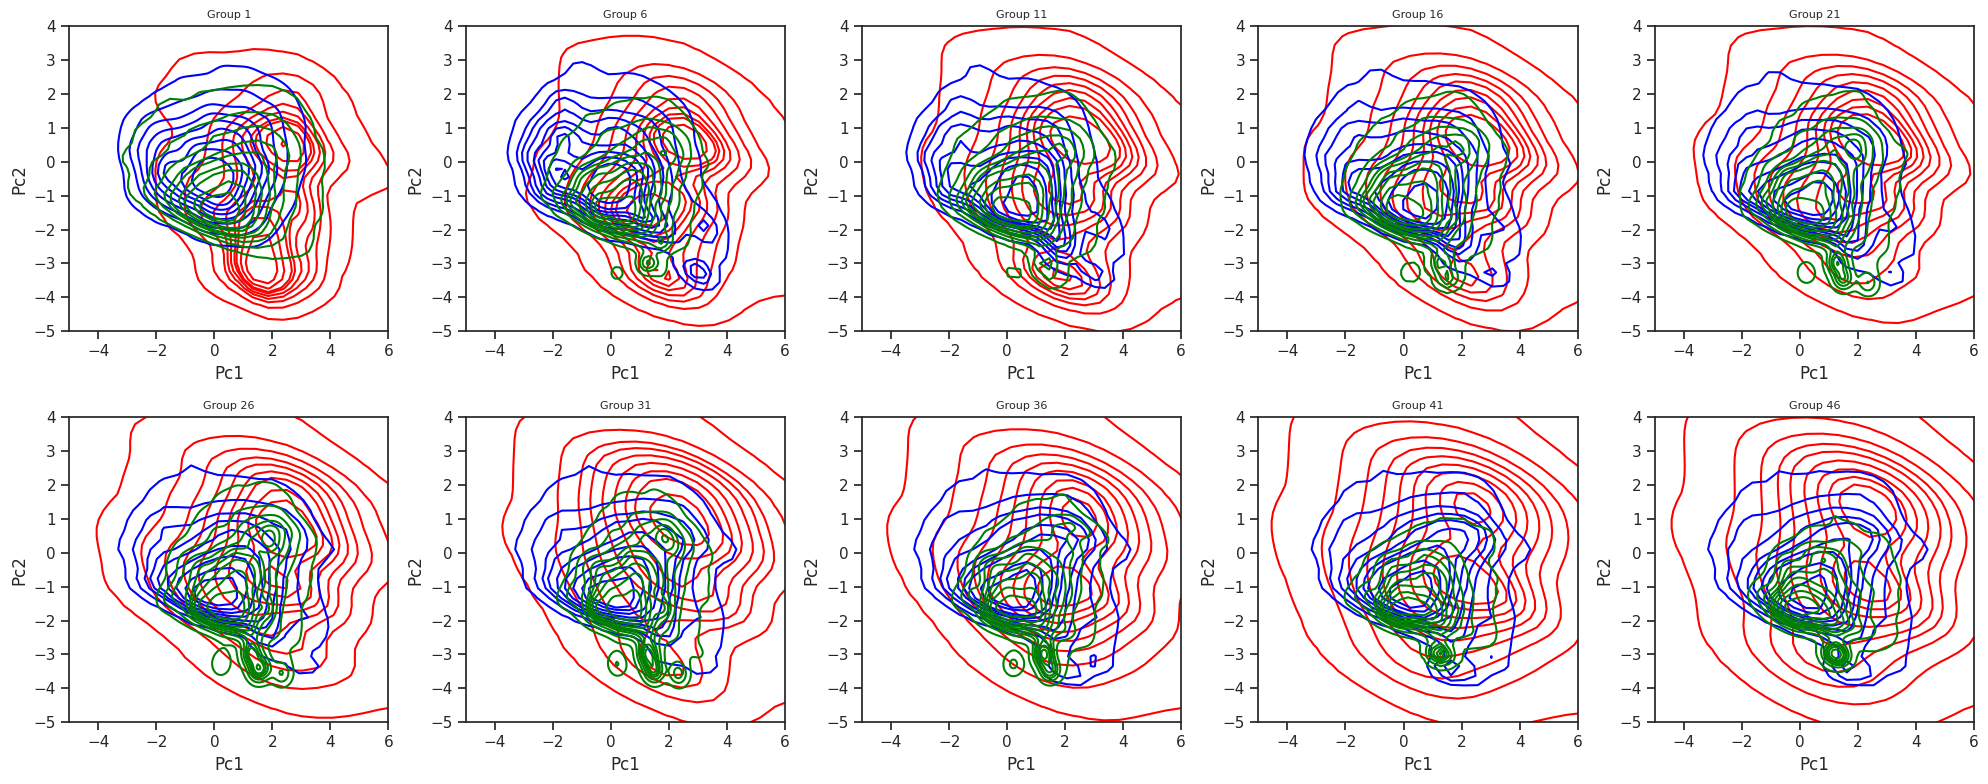

In [61]:
range_it = range(1, finalDfkde['first_it'].max()+1, 5)
N = len(range_it)

# Calculate the number of rows and columns needed for the grid
n_cols = 5
n_rows = math.ceil(N / n_cols)

sns.set_theme(style="ticks")
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))  # Adjust the figure size dynamically

# Flatten the axs array for easy iteration if there are multiple rows
axs = axs.flatten()

# pallet = {'labeled': 'blue', 'unlabelled': 'red'}
pallet = {True: 'blue', False: 'red'}
alpha_values = {True: 1, False: 0}

kde_list = []

for idx, it in enumerate(range_it):  # Loop through the number of unique first_its
    filtered_data = set_current_df(finalDfkde, df_all_kde, it)
    ax = axs[idx]

    for out_status in [-1,0,1]:
        subset = filtered_data[filtered_data["outNeg"] == out_status]
        
        sns.kdeplot(
            x="Pc1", y="Pc2", 
            data=subset,
            s=5, 
            color=pallet_out[out_status], 
            label=out_status,
            ax=ax,
            fill=False,
            legend=True,
        )

    # g = sns.kdeplot(
    #     x="Pc1", y="Pc2", 
    #     data=filtered_data,
    #     hue='labeled',
    #     fill=False,
    #     ax = ax,
    # )
    
    ax.set_title(f'Group {it}', fontsize=8)
    ax.set_ylim([-5, 4])
    ax.set_xlim([-5, 6])

# Turn off the axes for any remaining empty subplots
for j in range(it, n_rows * n_cols):
    fig.delaxes(axs[j])

plt.tight_layout()

plt.savefig(f'kde-pca_lines-{seed_number}-{year}-{size}-{p_value}-{contamination_threshold}.png')
# plt.show()


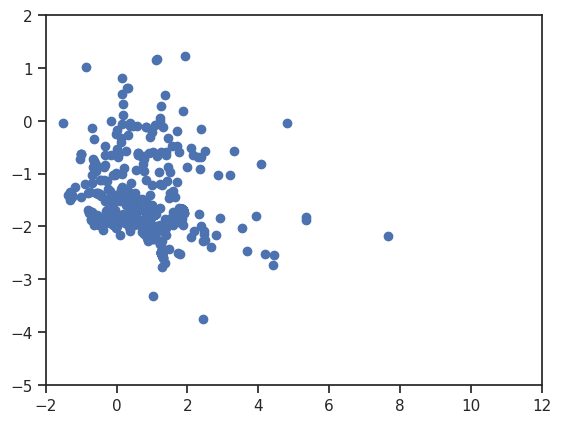

In [209]:
from IPython.display import clear_output

for i in range(50):
    clear_output(wait=True)
    x = finalDf.loc[finalDf['first_it'] == i, 'Pc1']
    y = finalDf.loc[finalDf['first_it'] == i, 'Pc2']
    plt.scatter(x=x, y=y)
    plt.xlim(-2, 12)  # Set x-axis limits
    plt.ylim(-5, 2)  # Set y-axis limits
    plt.show()
    plt.pause(0.5) 

In [ ]:
#plotar added, acp, and outliers

In [ ]:
sns.relplot(
    data=finalDf.query("first_it <= 10"),
    x="Pc1", y="Pc2", col="first_it", hue="rej",
    kind="scatter", s=5, palette="Set1",
    col_wrap=5  # Adjust this number based on how many columns you want per row
)

# Adjust the layout
plt.tight_layout()

# Show the plot
# plt.show()

In [74]:
it_mean = {}
for it in range(df_i.first_it.max()):
    cols_mean = {}
    df_it  = df_i.loc[(df_i.first_it <= it) & (df_i.first_it >= 0),:]
    for c in df_i.columns:
        cols_mean[c] = df_it.loc[:,c].mean()
    it_mean[it] = cols_mean

In [75]:
mean_df = pd.DataFrame(it_mean).drop(['addr_state', 'term', 'first_it']).T
mean_df

,emp_length,dti,loan_amnt,risk_score,int_rate,delinq_2yrs,annual_inc,inq_last_6mths,home_ownership,revol_util,label
0,4.908282,13.053928,10423.440052,684.759229,12.278685,0.146031,69280.201121,1.181313,0.140756,48.081940,0.141294
1,4.528503,126.104664,10317.772676,683.723814,12.113692,0.132687,69022.601475,1.199172,0.140543,45.858717,0.160769
2,4.202536,112.530254,10452.959739,677.394946,12.067570,0.122999,68918.791261,1.198966,0.140383,44.981460,0.175449
3,4.019458,123.563835,10481.400899,666.084603,12.071005,0.119162,69232.173307,1.187514,0.140258,44.669489,0.186911
4,3.902984,261.420903,10566.449516,658.422249,12.097833,0.116380,70549.505480,1.175459,0.140157,44.527153,0.196107
5,3.774411,330.467827,10626.207687,655.680521,12.152392,0.118009,70131.309189,1.163280,0.140075,45.058855,0.203650
6,3.631414,356.180267,10614.333187,653.657874,12.190749,0.117101,69389.085949,1.162143,0.140006,45.456987,0.209949
7,3.513374,415.783724,10554.467461,648.966488,12.222966,0.113512,68490.878140,1.171049,0.139948,45.816169,0.215287
8,3.398102,411.030668,10593.163222,647.968878,12.264856,0.113475,68206.429785,1.176108,0.139898,46.409791,0.219870
9,3.301647,386.116668,10592.590333,638.594300,12.251638,0.110435,67703.011106,1.167306,0.139854,46.566031,0.223846


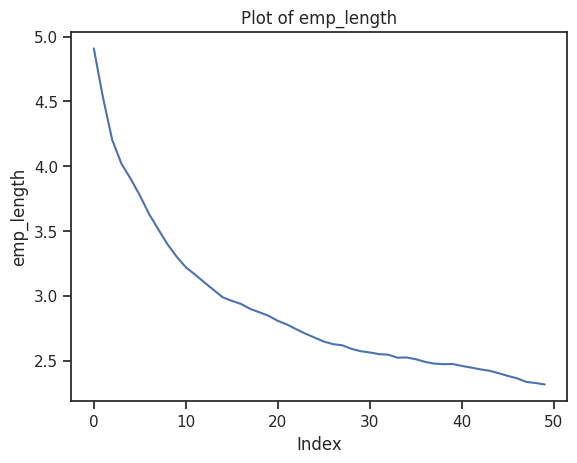

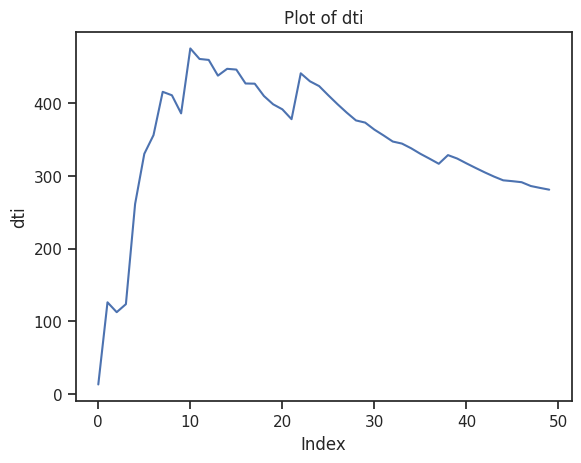

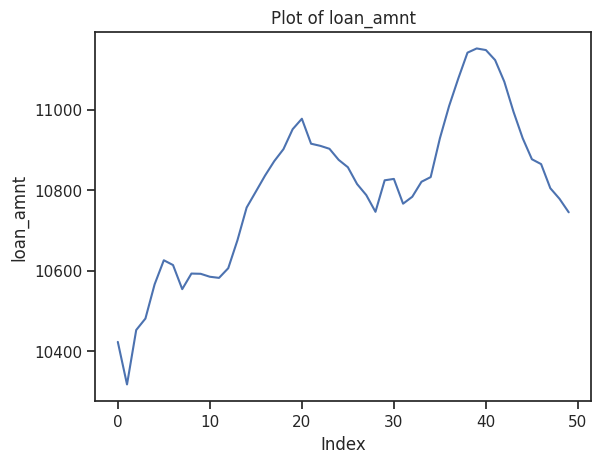

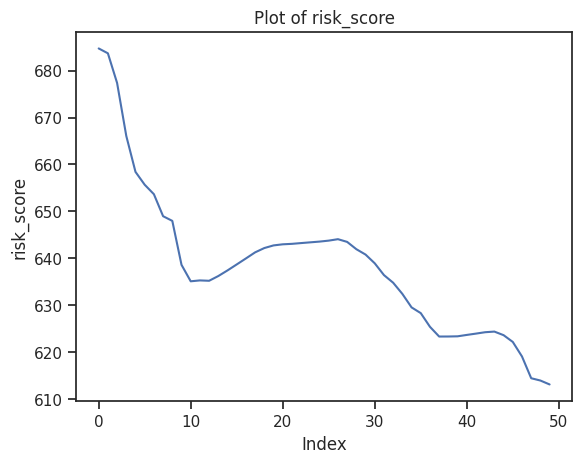

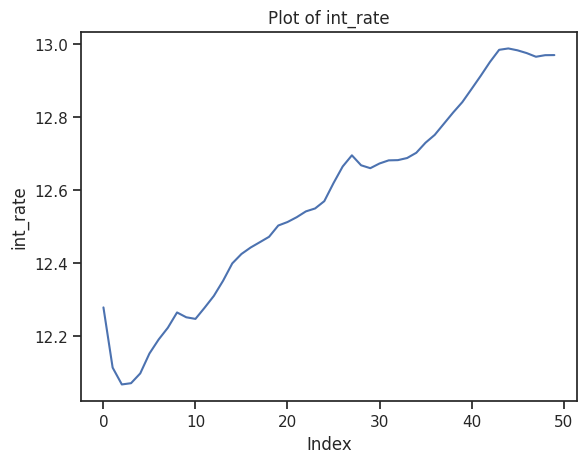

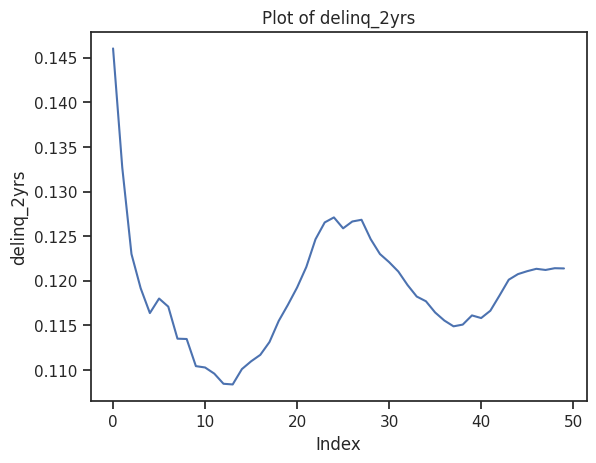

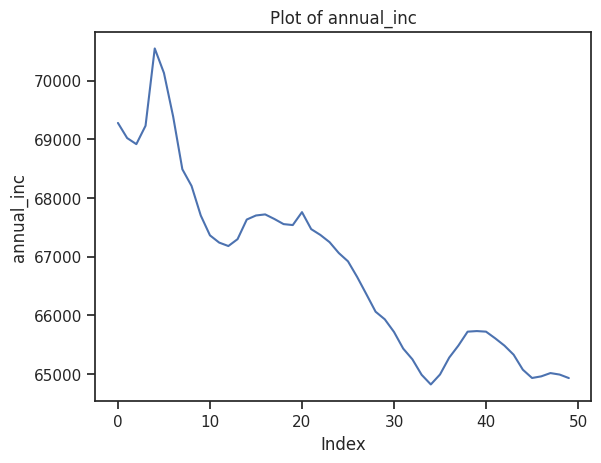

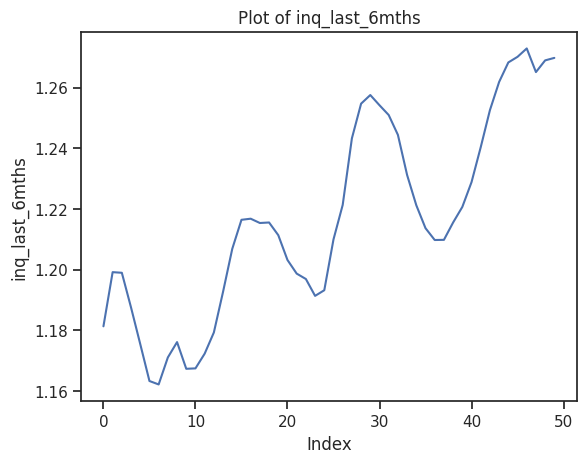

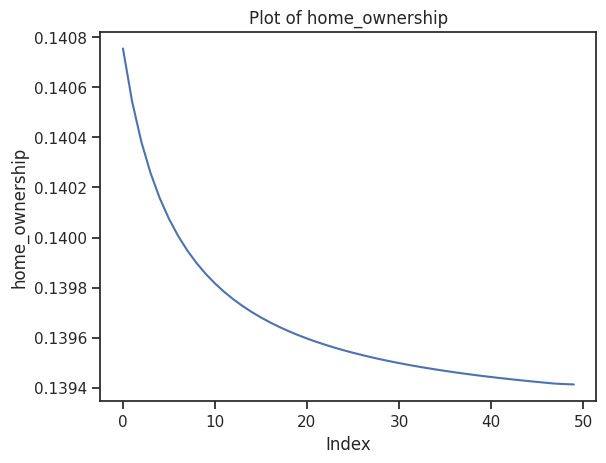

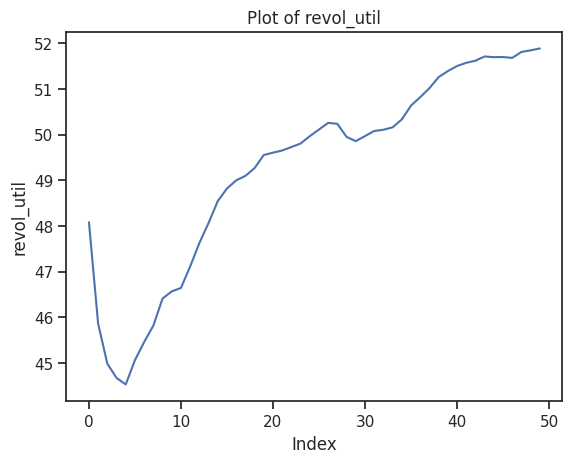

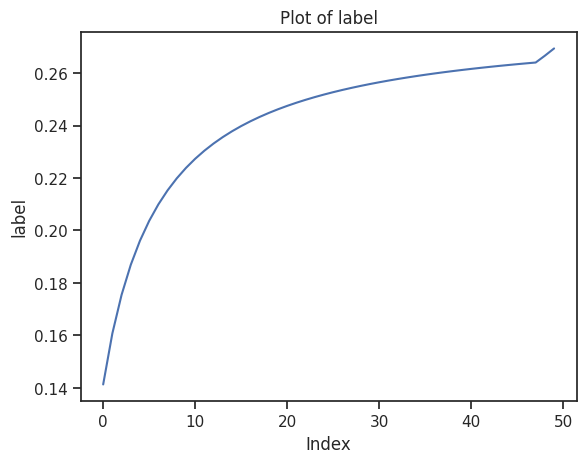

In [76]:
for column in mean_df.columns:
    plt.figure()  # Create a new figure for each plot
    plt.plot(mean_df[column])  # Plot the column data
    plt.title(f'Plot of {column}')  # Title with the name of the column
    plt.xlabel('Index')  # X-axis label, adjust if your index has specific meaning, e.g., 'Time' or 'Date'
    plt.ylabel(column)  # Y-axis label using the column name

    # Display the plot
    plt.show()


#about ci-ex

In [77]:
models_ex = os.path.join(ri_datasets_path,f'Models/TN-{year}/{seed_number}/{size}-{p_value}-{contamination_threshold}.joblib')
models_ex

'../data/riData/Models/TN-2010/388389/1000-0.28-0.12.joblib'

In [78]:
ci_ex = joblib.load(models_ex)

In [79]:
ci_ex.keys()

dict_keys(['BM', 'TN_1', 'TN_2', 'TN_3', 'TN_4', 'TN_5', 'TN_6', 'TN_7', 'TN_8', 'TN_9', 'TN_10', 'TN_11', 'TN_12', 'TN_13', 'TN_14', 'TN_15', 'TN_16', 'TN_17', 'TN_18', 'TN_19', 'TN_20', 'TN_21', 'TN_22', 'TN_23', 'TN_24', 'TN_25', 'TN_26', 'TN_27', 'TN_28', 'TN_29', 'TN_30', 'TN_31', 'TN_32', 'TN_33', 'TN_34', 'TN_35', 'TN_36', 'TN_37', 'TN_38', 'TN_39', 'TN_40', 'TN_41', 'TN_42', 'TN_43', 'TN_44', 'TN_45', 'TN_46', 'TN_47', 'TN_48', 'TN_49', 'TN_50'])

In [80]:
X_val

,emp_length,addr_state,dti,loan_amnt,risk_score,int_rate,delinq_2yrs,annual_inc,inq_last_6mths,term,home_ownership,revol_util
1642810,2.0,0.146791,13.40,25000.0,742.0,10.99,0.0,100000.00,1.0,36.0,0.150919,67.3
1643590,5.0,0.146707,22.62,25000.0,702.0,15.70,0.0,68902.67,0.0,36.0,0.126405,82.9
1642076,10.0,0.126354,24.38,16800.0,652.0,14.59,0.0,54000.00,3.0,36.0,0.126405,39.8
1652221,7.0,0.106176,19.45,5000.0,597.0,10.38,0.0,68000.00,4.0,36.0,0.126405,21.0
1639585,7.0,0.146791,13.20,5000.0,762.0,7.51,0.0,96000.00,0.0,36.0,0.126405,17.2
...,...,...,...,...,...,...,...,...,...,...,...,...
1644240,2.0,0.150803,11.93,12000.0,802.0,7.88,0.0,32000.00,0.0,36.0,0.126405,27.0
1639242,5.0,0.118386,20.09,1000.0,712.0,7.88,0.0,54000.00,0.0,60.0,0.126405,32.1
1644047,10.0,0.119596,13.80,10000.0,752.0,13.48,0.0,41300.00,0.0,36.0,0.150919,74.2
1644806,10.0,0.119014,2.13,2500.0,592.0,13.92,1.0,82400.00,0.0,36.0,0.150919,0.0


In [81]:
from sklearn.metrics import confusion_matrix

cm_dict = {}

for name, model in ci_ex.items():
    cm = confusion_matrix(y_val, model.predict(X_val))
    cm_dict[name] = cm
       

In [82]:
cm_dict

{'BM': array([[1682,  575],
        [  70,  297]]),
 'TN_1': array([[1745,  512],
        [  84,  283]]),
 'TN_2': array([[1788,  469],
        [  91,  276]]),
 'TN_3': array([[1826,  431],
        [  97,  270]]),
 'TN_4': array([[1851,  406],
        [ 104,  263]]),
 'TN_5': array([[1877,  380],
        [ 108,  259]]),
 'TN_6': array([[1889,  368],
        [ 115,  252]]),
 'TN_7': array([[1902,  355],
        [ 120,  247]]),
 'TN_8': array([[1908,  349],
        [ 123,  244]]),
 'TN_9': array([[1912,  345],
        [ 124,  243]]),
 'TN_10': array([[1926,  331],
        [ 125,  242]]),
 'TN_11': array([[1930,  327],
        [ 126,  241]]),
 'TN_12': array([[1928,  329],
        [ 125,  242]]),
 'TN_13': array([[1929,  328],
        [ 128,  239]]),
 'TN_14': array([[1932,  325],
        [ 126,  241]]),
 'TN_15': array([[1939,  318],
        [ 126,  241]]),
 'TN_16': array([[1939,  318],
        [ 122,  245]]),
 'TN_17': array([[1943,  314],
        [ 127,  240]]),
 'TN_18': array([[1941

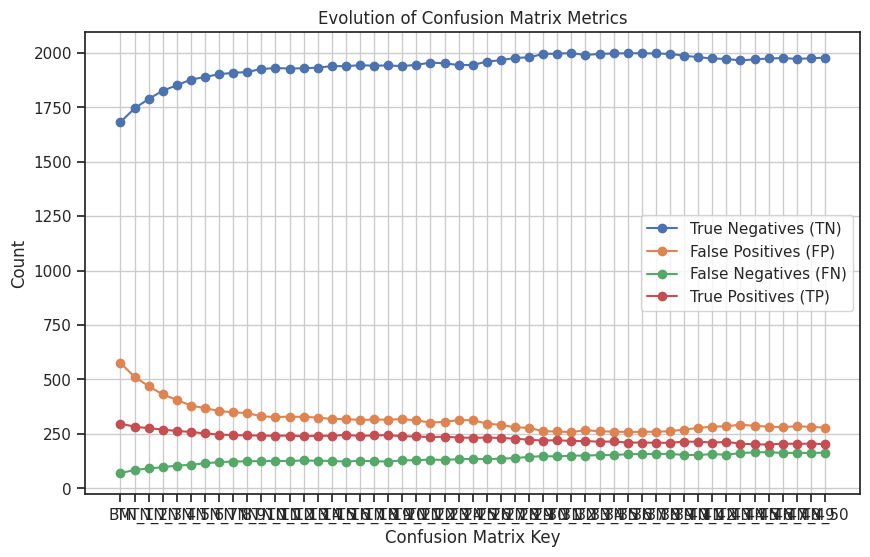

In [83]:








import matplotlib.pyplot as plt

# Confusion matrices
conf_matrices = cm_dict.copy()

# Extract TN, FP, FN, and TP
metrics = {'TN': [], 'FP': [], 'FN': [], 'TP': []}
for cm in conf_matrices.values():
    TN, FP = cm[0]
    FN, TP = cm[1]
    metrics['TN'].append(TN)
    metrics['FP'].append(FP)
    metrics['FN'].append(FN)
    metrics['TP'].append(TP)

# Plot the metrics
fig, ax = plt.subplots(figsize=(10, 6))

keys = list(conf_matrices.keys())
ax.plot(keys, metrics['TN'], label='True Negatives (TN)', marker='o')
ax.plot(keys, metrics['FP'], label='False Positives (FP)', marker='o')
ax.plot(keys, metrics['FN'], label='False Negatives (FN)', marker='o')
ax.plot(keys, metrics['TP'], label='True Positives (TP)', marker='o')

ax.set_xlabel('Confusion Matrix Key')
ax.set_ylabel('Count')
ax.set_title('Evolution of Confusion Matrix Metrics')
ax.legend()

plt.grid(True)
plt.show()
